In [4]:
import pandas as pd #importing necessary libraries 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
ingredients = pd.read_csv("D:/Guvi/Capstone/dominos_5/Pizza_ingredients - Pizza_ingredients.csv") #loading necessary datasets
sales=pd.read_csv("D:/Guvi/Capstone/dominos_5/Pizza_Sale - pizza_sales.csv")

In [6]:
print("Dataset Overview:")
print(sales.info())  # Data types, non-null count
print("\nSummary Statistics for Numerical Columns:")
print(sales.describe())  # Summary statistics for numerical columns
# Count missing values per column
print("\nMissing Data Count per Column:")
missing_values = sales.isnull().sum()
print(missing_values)
# Display rows that have missing data
print("\nRows with Missing Data:")
print(sales[sales.isnull().any(axis=1)])  # Display rows with missing values
sales['total_price'] = sales['total_price'].interpolate(method='linear') #null value imputing using interpolate method
# Select columns for imputation
columns_to_impute = ['pizza_name_id', 'pizza_name', 'pizza_ingredients', 'pizza_category']
# Function to fill missing values in the specified column using other columns
def fill_missing_values(data, column_to_fill, reference_columns):
    for idx, row in data[data[column_to_fill].isnull()].iterrows():
        ref_values = row[reference_columns]
        matching_row = data[(data[reference_columns] == ref_values).all(axis=1) & data[column_to_fill].notnull()]
        if not matching_row.empty:
            data.at[idx, column_to_fill] = matching_row[column_to_fill].values[0]
# Apply the function to each column with missing values
for column in columns_to_impute:
    ref_columns = [col for col in columns_to_impute if col != column]
    fill_missing_values(sales, column, ref_columns)
duplicate_rows = sales[sales.duplicated()]
print(f"\nNumber of Duplicate Rows: {len(duplicate_rows)}")
print(duplicate_rows)
print("Dataset Overview:")
print(ingredients.info())  # Data types, non-null count
print("\nSummary Statistics for Numerical Columns:")
print(ingredients.describe())  # Summary statistics for numerical columns
# Count missing values per column
print("\nMissing Data Count per Column:")
missing_values = ingredients.isnull().sum()
print(missing_values)
# Display rows that have missing data
print("\nRows with Missing Data:")
print(ingredients[ingredients.isnull().any(axis=1)])  # Display rows with missing values
ingredients['Items_Qty_In_Grams'] = ingredients['Items_Qty_In_Grams'].interpolate(method='linear')

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None

Summary Statistics for Numerical Columns:
           pizza_id      order_id      quantity    unit_price   total_price
count  48620.00

In [7]:
sales.info()
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48620 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48620 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48620 non-null  object 
 10  pizza_ingredients  48620 non-null  object 
 11  pizza_name         48620 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
--- 

In [8]:
from scipy.stats.mstats import winsorize
def winsorize_outliers(df, columns, lower_percentile=0.01, upper_percentile=0.99):
    for col in columns:
        if df[col].dtype != 'object':  # Only apply to numerical columns
            original_size = len(df)
            df[col] = winsorize(df[col], limits=[lower_percentile, upper_percentile])  # Winsorize data
            print(f" - Winsorized outliers in {col} using Winsorization method")
    return df
# Applying Winsorization method for outlier treatment
numerical_columns = ['quantity', 'unit_price', 'total_price']
sales = winsorize_outliers(sales, numerical_columns)
print(f"\nNumber of Duplicate Rows Before Removal: {len(sales[sales.duplicated()])}")
# Remove duplicate rows
sales.drop_duplicates(inplace=True)
print(f"Number of Duplicate Rows After Removal: {len(sales[sales.duplicated()])}")

 - Winsorized outliers in quantity using Winsorization method
 - Winsorized outliers in unit_price using Winsorization method
 - Winsorized outliers in total_price using Winsorization method

Number of Duplicate Rows Before Removal: 0
Number of Duplicate Rows After Removal: 0


In [9]:
#Feature Engineering
from dateutil import parser
def custom_date_parser(date_str):
    # Try parsing with the common formats
    formats = ['%d-%m-%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue
    # Fallback to dateutil's parser if all else fails
    try:
        return parser.parse(date_str, dayfirst=True)
    except (ValueError, TypeError):
        return pd.NaT  # Return NaT if parsing fails

sales['order_date'] = sales['order_date'].apply(custom_date_parser)
sales['order_time'] = pd.to_datetime(sales['order_time'], format='%H:%M:%S', errors='coerce')
sales['order_hour'] = sales['order_time'].dt.hour
def get_time_of_day(order_hour):
       if 6 <= order_hour < 12:
           return 'morning'
       elif 12 <= order_hour < 18:
           return 'afternoon'
       else:
           return 'evening'
# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

sales['time_of_day'] = sales['order_hour'].apply(get_time_of_day)
#sales['day'] = sales['order_time'].dt.day
sales['day_of_week'] = sales['order_date'].dt.dayofweek #0 - Monday, 6 - Sunday
sales['Month'] = sales['order_date'].dt.month
sales['season'] = sales['order_date'].dt.month.apply(get_season) 
sales = sales.drop(['order_time'], axis=1)

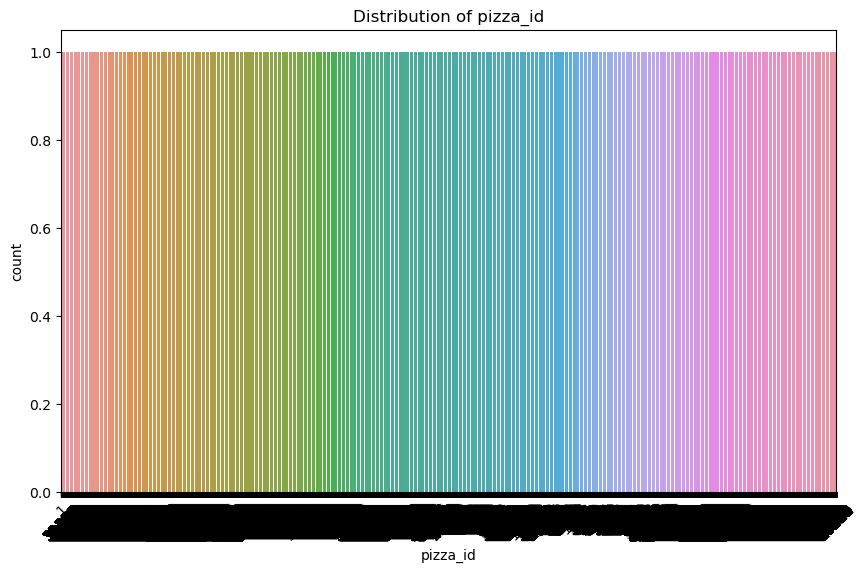


Distribution analysis for pizza_id:
 - There are 48620 unique values in pizza_id.
 - The most frequent value is '1' with 1 occurrences.
 - The distribution is balanced.


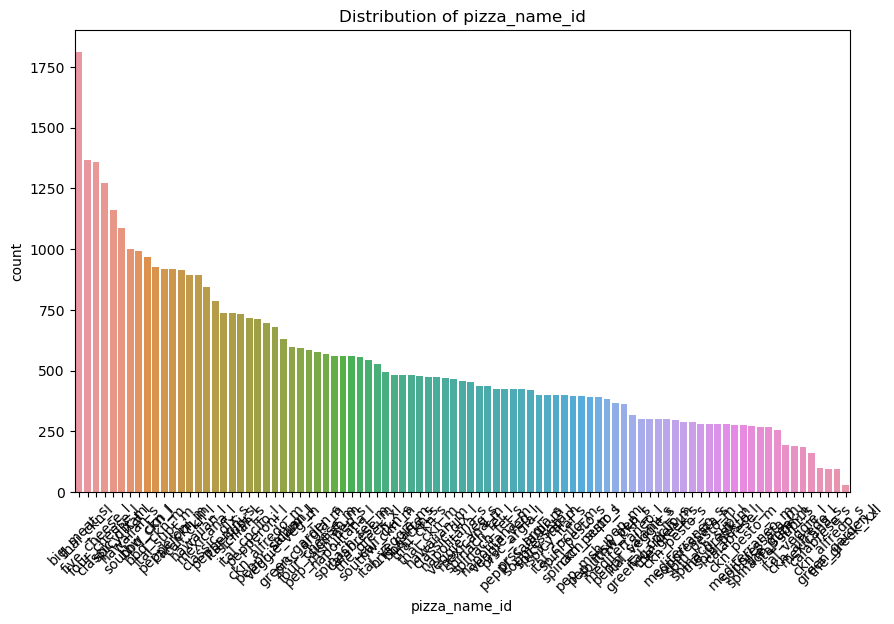


Distribution analysis for pizza_name_id:
 - There are 91 unique values in pizza_name_id.
 - The most frequent value is 'big_meat_s' with 1811 occurrences.
 - The distribution is balanced.


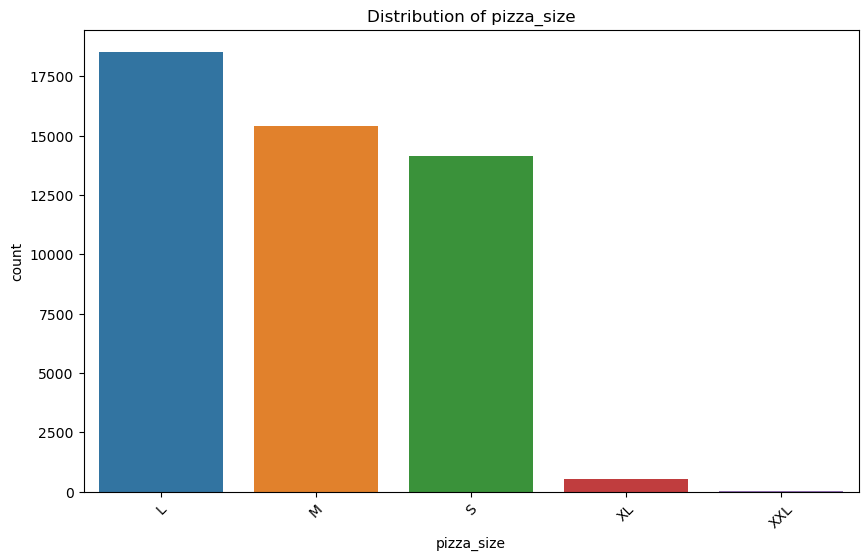


Distribution analysis for pizza_size:
 - There are 5 unique values in pizza_size.
 - The most frequent value is 'L' with 18526 occurrences.
 - The distribution is balanced.


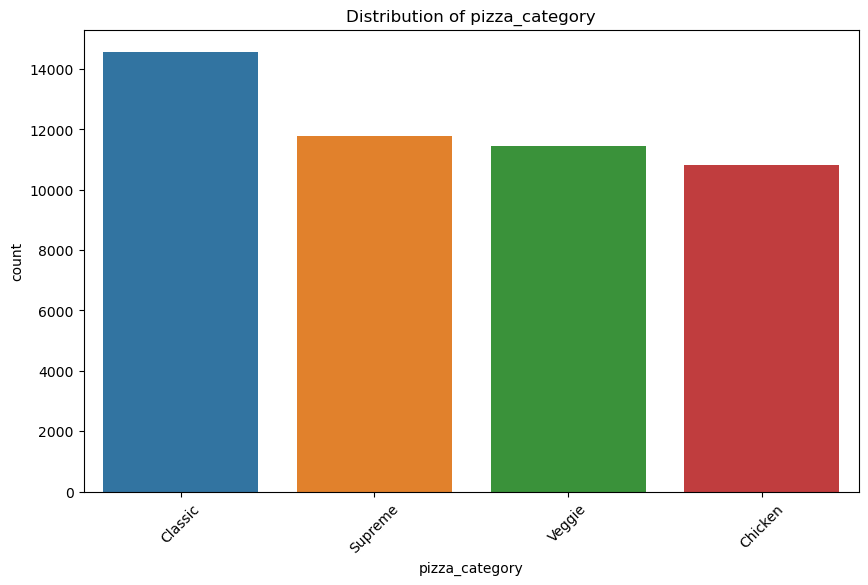


Distribution analysis for pizza_category:
 - There are 4 unique values in pizza_category.
 - The most frequent value is 'Classic' with 14579 occurrences.
 - The distribution is balanced.


C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


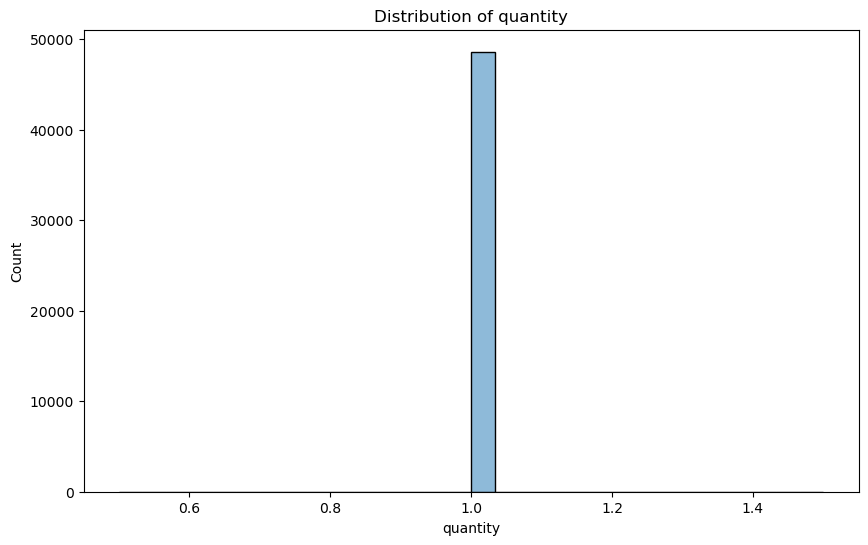


Distribution analysis for quantity:
 - Mean: 1.0
 - Median: 1.0
 - The distribution is fairly normal.


C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


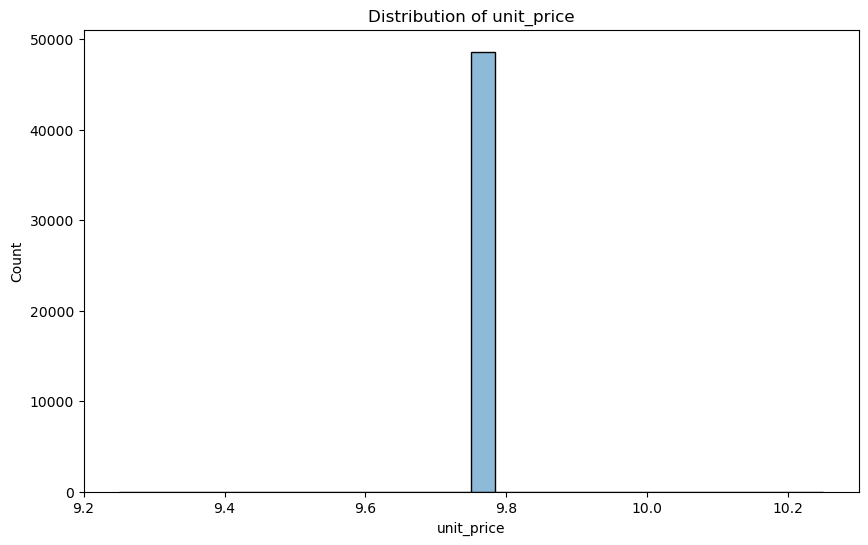

C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



Distribution analysis for unit_price:
 - Mean: 9.75
 - Median: 9.75
 - The distribution is fairly normal.


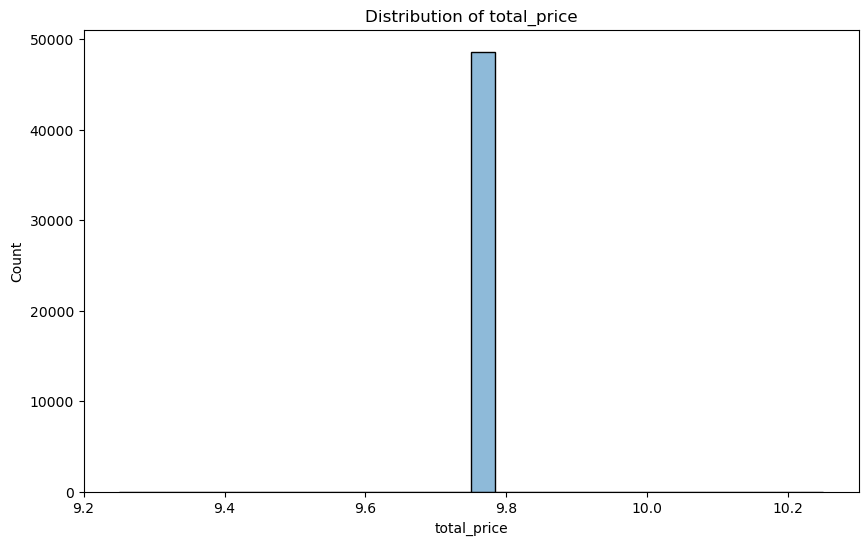


Distribution analysis for total_price:
 - Mean: 9.75
 - Median: 9.75
 - The distribution is fairly normal.


In [10]:
categorical_columns = ['pizza_id', 'pizza_name_id', 'pizza_size', 'pizza_category']
numerical_columns = ['quantity', 'unit_price', 'total_price']
for col in categorical_columns:
    if col in sales.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=col, data=sales, order=sales[col].value_counts().index)
        plt.title(f"Distribution of {col}")
        plt.xticks(rotation=45)
        plt.show()
    
        print(f"\nDistribution analysis for {col}:")
        print(f" - There are {sales[col].nunique()} unique values in {col}.")
        print(f" - The most frequent value is '{sales[col].mode()[0]}' with {sales[col].value_counts().iloc[0]} occurrences.")
        print(f" - The distribution is {'skewed' if sales[col].value_counts().iloc[0] / len(sales) > 0.5 else 'balanced'}.")

# ===============================
# Distribution Analysis for Numerical Variables
# ===============================
for col in numerical_columns:
    if col in sales.columns:
        plt.figure(figsize=(10, 6))
        sns.histplot(sales[col], bins=30, kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()
    
        print(f"\nDistribution analysis for {col}:")
        print(f" - Mean: {sales[col].mean()}")
        print(f" - Median: {sales[col].median()}")
        print(f" - The distribution {'has a skew' if abs(sales[col].skew()) > 0.5 else 'is fairly normal'}.")

C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)



Correlation Matrix:
              quantity  unit_price  total_price
quantity          NaN         NaN          NaN
unit_price        NaN         NaN          NaN
total_price       NaN         NaN          NaN


C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


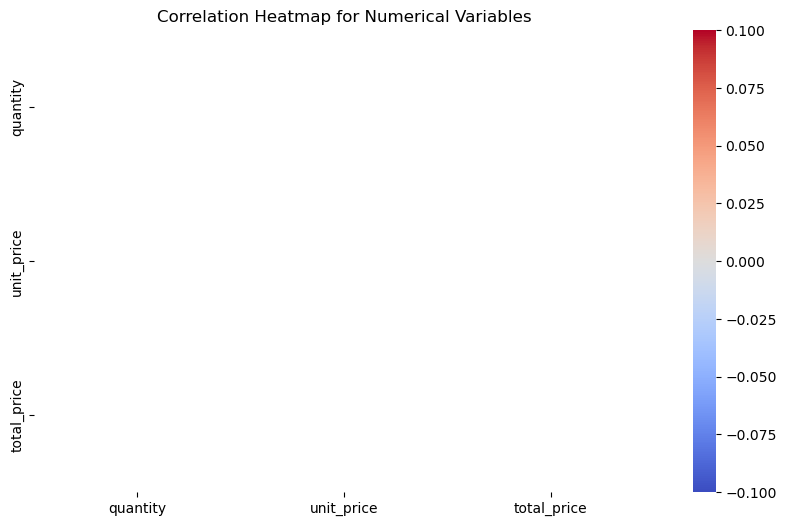


Correlation Analysis:
 - 'quantity' has no strong correlations with other numerical variables.
 - 'unit_price' has no strong correlations with other numerical variables.
 - 'total_price' has no strong correlations with other numerical variables.


In [11]:
# Correlation matrix for numerical variables
corr_matrix = sales[numerical_columns].corr()
print("\nCorrelation Matrix:\n", corr_matrix)

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for Numerical Variables")
plt.show()
print("\nCorrelation Analysis:")
for col in numerical_columns:
    high_corr = corr_matrix[col][corr_matrix[col] > 0.5]
    if len(high_corr) > 0:
        print(f" - '{col}' is highly correlated with {', '.join(high_corr.index)} (correlation > 0.5).")
    else:
        print(f" - '{col}' has no strong correlations with other numerical variables.")

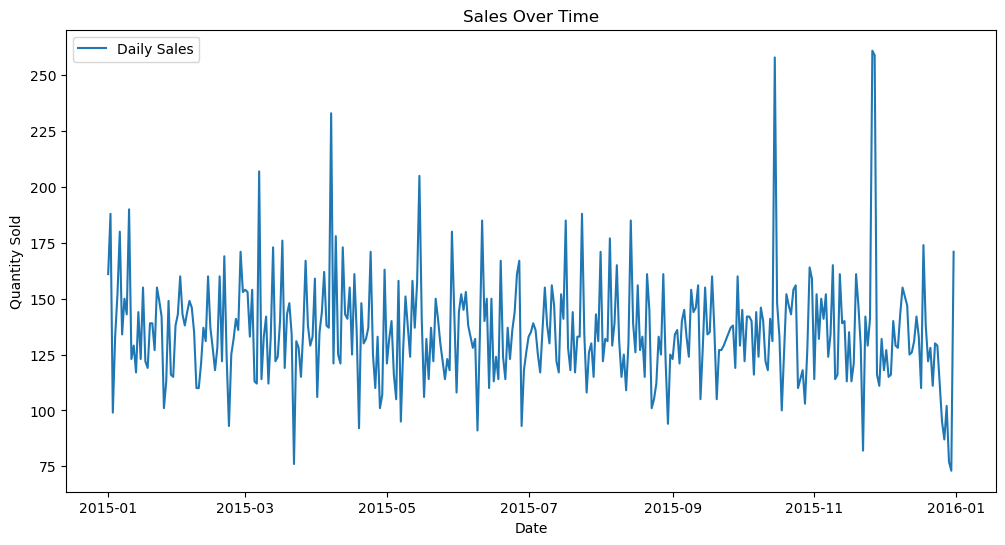


Time Series Analysis of Sales Over Time:
 - Total number of sales records: 358
 - Sales peaks around certain dates, which could indicate promotions or seasonal trends.
 - There is significant volatility in daily sales.


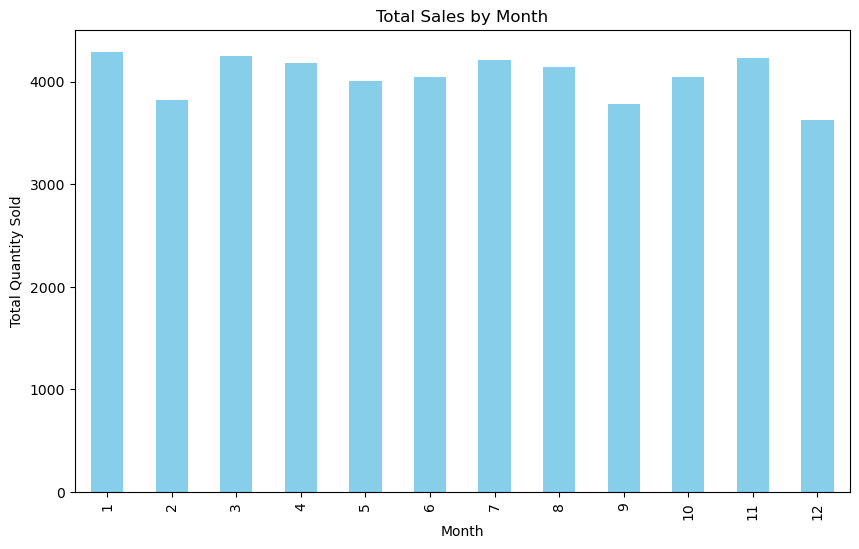


Monthly Sales Trend:
 - The highest sales occurred in month 1 with 4288 units sold.
 - The lowest sales occurred in month 12 with 3622 units sold.
 - There is no strong seasonal pattern in sales.

Sales Trend by Hour of Day:


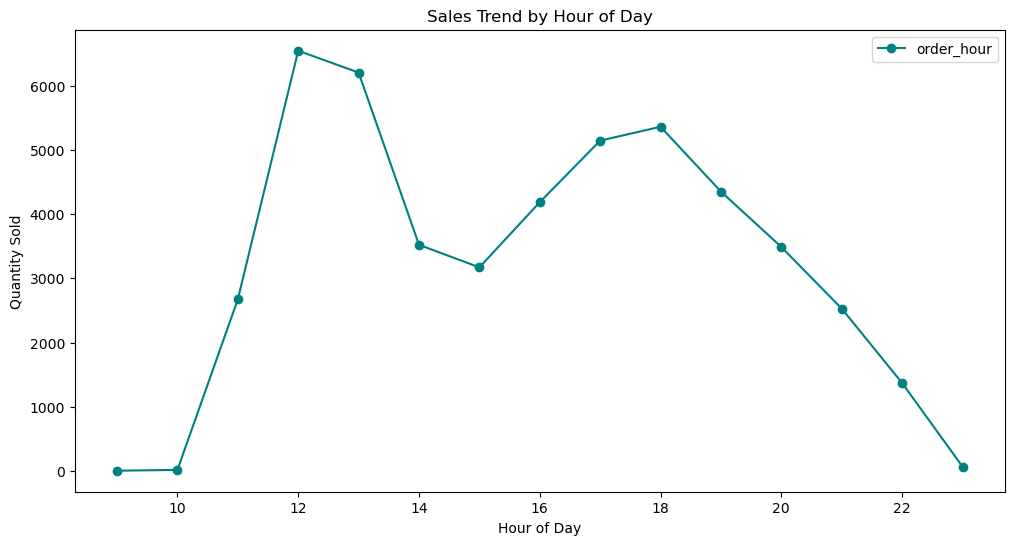


Sales Trend by Hour of Day Analysis:
 - Sales vary significantly by hour of the day, with peak hours showing higher quantities sold.
 - The highest sales occur at hour 12 with 6543 units sold.
 - The lowest sales occur at hour 9 with 4 units sold.
 - This pattern can help in optimizing staffing and inventory levels based on expected sales.

Heatmap of Average Sales by Hour and Day:


C:\Users\Madhava\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


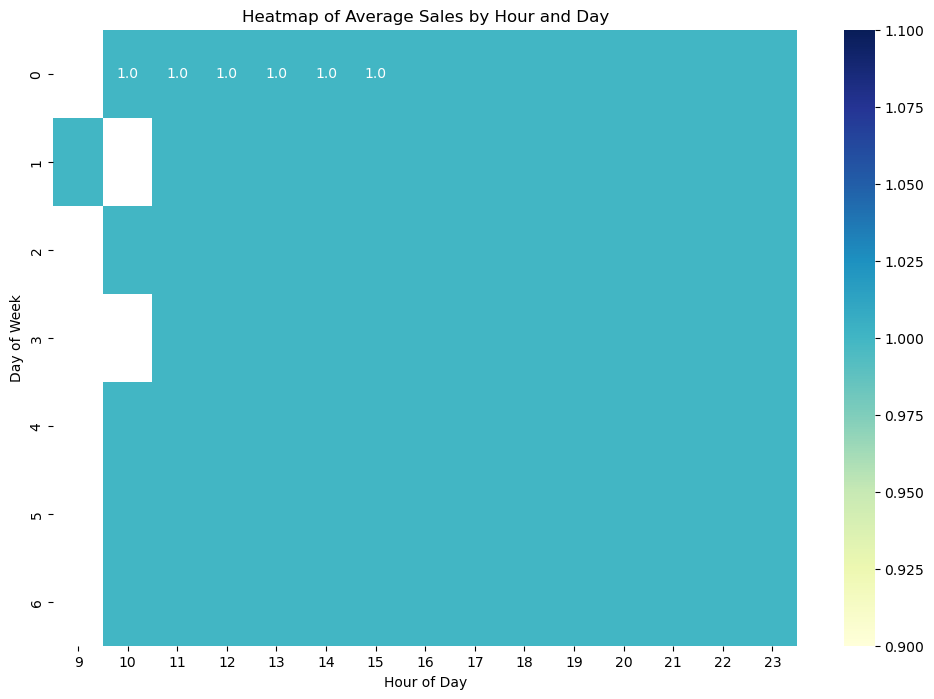


Heatmap of Average Sales by Hour and Day Analysis:
 - The heatmap shows how average sales vary across different days of the week and hours of the day.
 - Peak sales hours and days are indicated by darker colors.
 - This visualization helps identify optimal times for promotions and staffing.

Impact of Season:
season
Fall      0.247861
Spring    0.255882
Summer    0.254977
Winter    0.241279
Name: quantity, dtype: float64
 - The highest sales occurred in month Spring with 0.25588235294117645 units sold.
 - The lowest sales occurred in month Winter with 0.24127930892636776 units sold.
 - There is no strong seasonal pattern in sales.


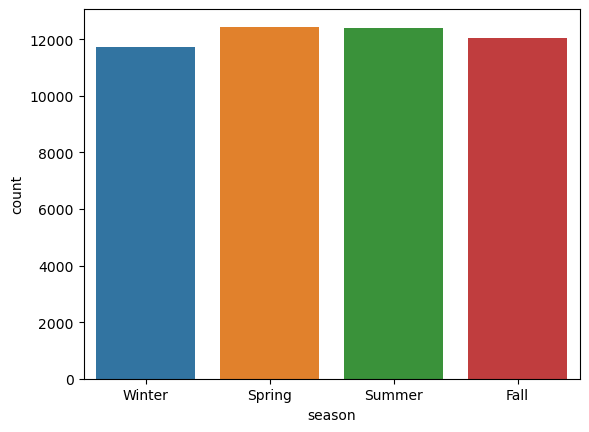

In [12]:
# Plot sales over time
sales_by_date = sales.groupby('order_date')['quantity'].sum()
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date, label='Daily Sales')
plt.title("Sales Over Time")
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()
print("\nTime Series Analysis of Sales Over Time:")
print(f" - Total number of sales records: {len(sales_by_date)}")
print(f" - Sales peaks around certain dates, which could indicate promotions or seasonal trends.")
print(f" - There {'is' if sales_by_date.diff().std() > 10 else 'is no'} significant volatility in daily sales.")

# Monthly sales trends
sales['Month'] = sales['order_date'].dt.month
monthly_sales = sales.groupby('Month')['quantity'].sum() # Changed df to sales

plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.show()
print("\nMonthly Sales Trend:")
print(f" - The highest sales occurred in month {monthly_sales.idxmax()} with {monthly_sales.max()} units sold.")
print(f" - The lowest sales occurred in month {monthly_sales.idxmin()} with {monthly_sales.min()} units sold.")
print(f" - There is {'clear monthly' if monthly_sales.max() > 1.5 * monthly_sales.mean() else 'no strong seasonal pattern'} in sales.")
# Sales Trend by Hour of Day
print("\nSales Trend by Hour of Day:")
plt.figure(figsize=(12, 6))
sales_by_hour = sales.groupby('order_hour')['quantity'].sum()
plt.plot(sales_by_hour, label='order_hour', marker='o', color='teal')
plt.title('Sales Trend by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Quantity Sold')
plt.legend()
plt.show()

print("\nSales Trend by Hour of Day Analysis:")
print(f" - Sales vary significantly by hour of the day, with peak hours showing higher quantities sold.")
print(f" - The highest sales occur at hour {sales_by_hour.idxmax()} with {sales_by_hour.max()} units sold.")
print(f" - The lowest sales occur at hour {sales_by_hour.idxmin()} with {sales_by_hour.min()} units sold.")
print(f" - This pattern can help in optimizing staffing and inventory levels based on expected sales.")

# Heatmap of Average Sales by Hour and Day
print("\nHeatmap of Average Sales by Hour and Day:")
plt.figure(figsize=(12, 8))
heatmap_data = sales.groupby(['day_of_week', 'order_hour'])['quantity'].mean().unstack()
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Heatmap of Average Sales by Hour and Day')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

print("\nHeatmap of Average Sales by Hour and Day Analysis:")
print(f" - The heatmap shows how average sales vary across different days of the week and hours of the day.")
print(f" - Peak sales hours and days are indicated by darker colors.")
print(f" - This visualization helps identify optimal times for promotions and staffing.")
#season
season_impact = sales.groupby('season')['quantity'].sum() / sales['quantity'].sum()
sns.countplot(x='season', data=sales)
print(f"\nImpact of Season:\n{season_impact}") 
print(f" - The highest sales occurred in month {season_impact.idxmax()} with {season_impact.max()} units sold.")
print(f" - The lowest sales occurred in month {season_impact.idxmin()} with {season_impact.min()} units sold.")
print(f" - There is {'clear seasonality' if season_impact.max() > 1.5 * season_impact.mean() else 'no strong seasonal pattern'} in sales.")

In [13]:
#month, season has no impact since removing the data 
sales = sales.drop(['Month'], axis=1)
sales = sales.drop(['season'], axis=1)

In [14]:
df = pd.merge(sales,ingredients, on='pizza_name_id',how='inner')

C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_ind

MAPE: 0.3057431379118488


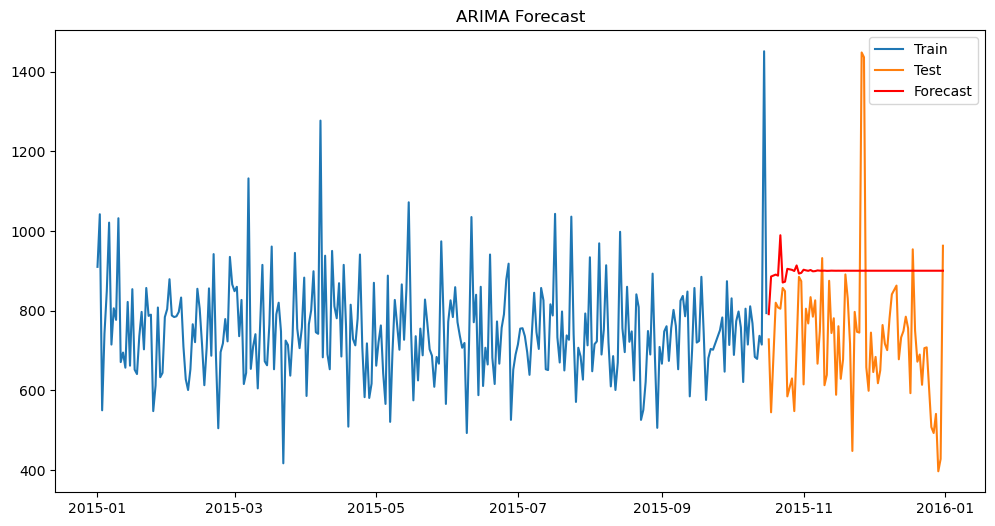

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Prepare data
df_daily = df.groupby('order_date')['quantity'].sum().reset_index()
df_daily.set_index('order_date', inplace=True)

# Split into train and test sets
train_size = int(0.8 * len(df_daily))
train = df_daily[:train_size]
test = df_daily[train_size:]
# Fit ARIMA model
model = ARIMA(train, order=(5,1,0)) # Example order, you may need to tune this
model_fit = model.fit()

# Make predictions for the test data 
forecast = model_fit.predict(start=len(train), end=len(df_daily)-1) # Use predict for in-sample predictions

# Evaluate the model on the test data 
mape = mean_absolute_percentage_error(test['quantity'], forecast)
print(f'MAPE: {mape}')

# Plot predictions 
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red') # Use test index for forecast
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Madhava\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get

MAPE: 0.3720052531944213


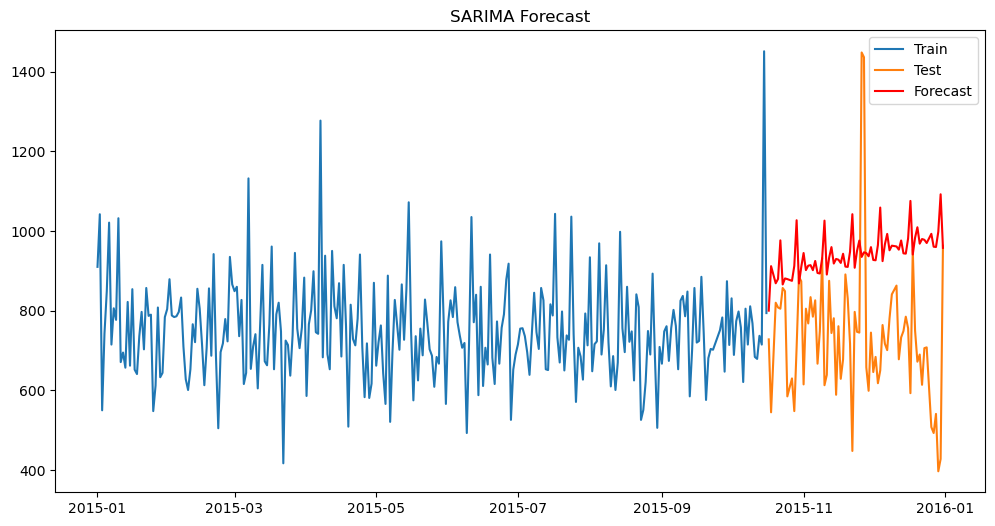

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error
# Fit SARIMA model
model = SARIMAX(train, order=(5,1,0), seasonal_order=(1,1,1,12)) 
model_fit = model.fit()

# Make predictions for the test data 
forecast = model_fit.predict(start=len(train), end=len(df_daily)-1) # Use predict for in-sample predictions

# Evaluate the model on the test data 
mape = mean_absolute_percentage_error(test['quantity'], forecast)
print(f'MAPE: {mape}')

# Plot predictions 
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red') # Use test index for forecast
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

14:06:04 - cmdstanpy - INFO - Chain [1] start processing
14:06:04 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 1.3404808009107221e+17


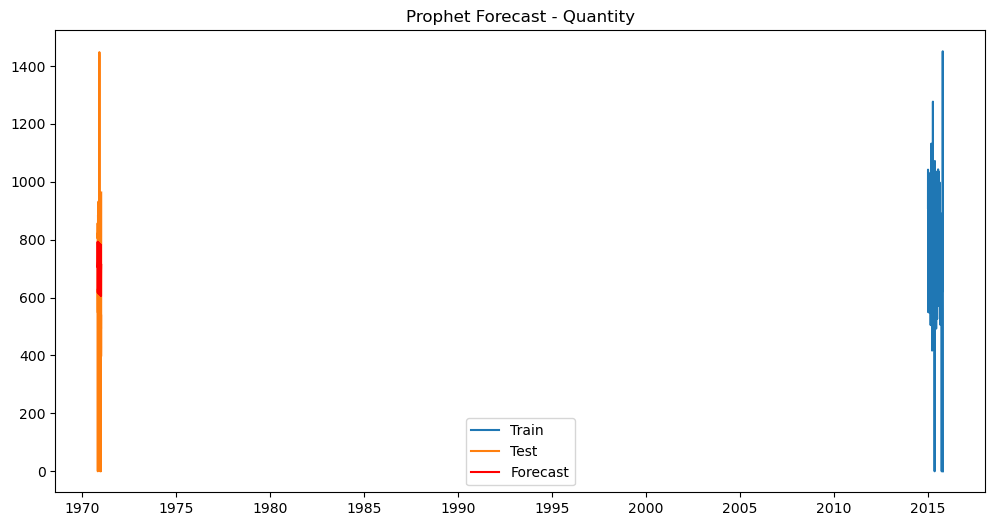

In [17]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
df_daily = df[['order_date', 'quantity']].rename(columns={'order_date': 'ds', 'quantity': 'y'})
df_daily = df_daily.set_index('ds').resample('D').sum().reset_index()

# Split data into train and test sets
# Calculate the index for splitting the data
train_data_index = int(len(df_daily) * 0.8)
# Use the index to split the data into train and test sets
train, test = df_daily[:train_data_index], df_daily[train_data_index:]

# Fit Prophet model
model = Prophet()
model.fit(train) 

# Create future dataframe for predictions
future = model.make_future_dataframe(periods=len(test))

# Make predictions
forecast = model.predict(future)['yhat'][len(train):]

# Evaluate the model 
mape = mean_absolute_percentage_error(test['y'], forecast)
print(f'MAPE: {mape}')

# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Prophet Forecast - Quantity')
plt.legend()
plt.show()

C:\Users\Madhava\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2053
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0212 
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0155 
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0141 
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 
Epoch 14/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 
Epoch 15/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 
Epoch 16/20
9/9 ━━━━━━━━━━━━━━━━━━━

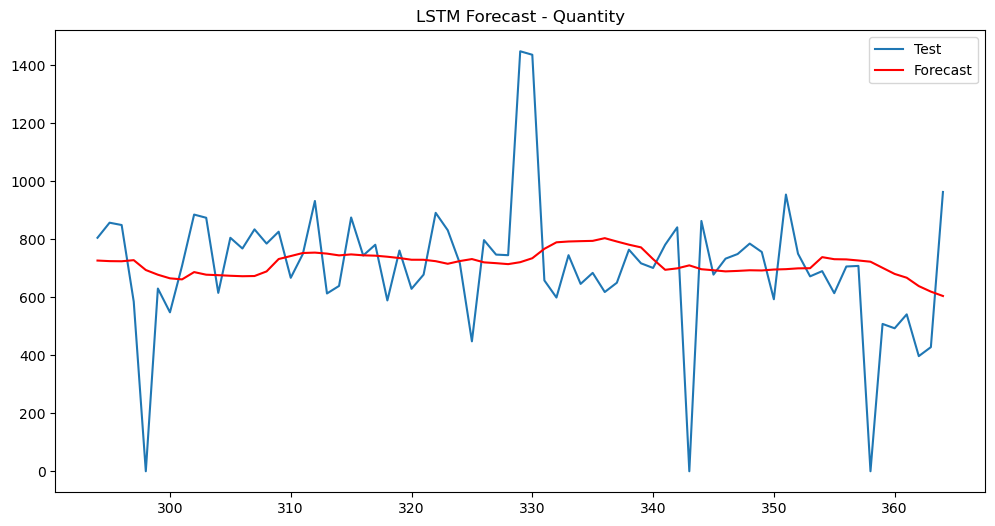

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Assuming df_daily has columns 'ds' (dates) and 'y' (values)
df_daily_values = df_daily['y'].values.reshape(-1, 1) # Select only the 'y' column for scaling

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_daily_values) # Scale the values 

# Create dataset with lookback
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X, y = create_dataset(scaled_data, look_back)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Forecast
predicted_scaled = model.predict(X_test)
predicted = scaler.inverse_transform(predicted_scaled)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
mape = mean_absolute_percentage_error(y_test, predicted)
print(f'LSTM MAPE: {mape}')

# Plot 
plt.figure(figsize=(12, 6))

# Use the correct index for plotting
plt.plot(df_daily.index[-len(y_test):], y_test, label='Test')
plt.plot(df_daily.index[-len(y_test):], predicted, label='Forecast', color='red')

plt.title('LSTM Forecast - Quantity')
plt.legend()
plt.show()

In [ ]:
# MAPE results
results = {
    'ARIMA': 0.3063118189733449,
    'SARIMA': 0.37301254891366664,
    'Prophet':  1.340193053196412e+17,
    'LSTM': 1.3757185500424752e+17,}
# Plot MAPE values
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('MAPE')
plt.title('Model Performance Comparison Based on MAPE')
plt.yscale('log') 
plt.show()

In [ ]:
# Mock future sales predictions for the next 7 days (since the sales model isn't available)
future_predictions = model_fit.forecast(steps=7)   

# Function to calculate ingredient requirements based on predicted sales
def calculate_ingredients(predicted_sales, ingredient_data):
    # Initialize a dictionary to hold ingredient requirements
    ingredient_requirements = {}

    # For each predicted day of sales
    for i, df_daily in enumerate(predicted_sales):
        print(f"Day {i+1} Sales Prediction:{round(df_daily)}")

        # Get unique pizza types from the ingredient dataset
        unique_pizza_types = ingredient_data['pizza_name_id'].unique()
        num_pizza_types = len(unique_pizza_types)
        
        # Proportionally distribute sales across pizza types
        for pizza in unique_pizza_types:
            pizza_sales = df_daily / num_pizza_types  # Simple proportional split
            ingredients_for_pizza = ingredient_data[ingredient_data['pizza_name_id'] == pizza]

            # Calculate the required ingredients for each pizza type
            for _, row in ingredients_for_pizza.iterrows():
                ingredient = row['pizza_ingredients'] # Access the correct column 'pizza_ingredients'
                quantity_needed = pizza_sales * row['Items_Qty_In_Grams']

                # Add up the quantities required for the predicted period
                if ingredient in ingredient_requirements:
                    ingredient_requirements[ingredient] += quantity_needed
                else:
                    ingredient_requirements[ingredient] = quantity_needed

    return ingredient_requirements

# Calculate the ingredients required for the predicted sales
ingredient_requirements = calculate_ingredients(future_predictions, ingredients) # Use the correct DataFrame 'ingredients'

# Create a purchase order DataFrame
purchase_order = pd.DataFrame(ingredient_requirements.items(), columns=['Ingredient', 'Quantity'])

# Display the purchase order
print(purchase_order)